In [1]:
import sys
import os
from pathlib import Path
sys.path.append("/Users/jdli/Project/Korg.jl/Jorg/src/")        

# Updated imports for new Jorg structure (mirrors Korg.jl)
from jorg.synthesis import synth
from jorg.lines.linelist import read_linelist
linelist_path = "/Users/jdli/Project/Korg.jl/data/linelists/vald_extract_stellar_solar_threshold001.vald"
# linelist_path = Path("/Users/jdli/Project/Korg.jl/data/linelists/GALAH_DR3/galah_dr3_linelist.h5")
linelist = read_linelist(str(linelist_path))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/jdli/Project/Korg.jl/Jorg/src/jorg/lines/linelist.py:208: UserWarning: Could not detect format for /Users/jdli/Project/Korg.jl/data/linelists/vald_extract_stellar_solar_threshold001.vald, assuming VALD
  warnings.warn(f"Could not detect format for {filename}, assuming VALD")


📖 Reading linelist: vald_extract_stellar_solar_threshold001.vald
   Format: vald
   Wavelength unit: auto
   Found 41880 data lines
   Successfully parsed 36197 lines


/Users/jdli/Project/Korg.jl/Jorg/src/jorg/lines/broadening_korg.py:210: RuntimeWarning: divide by zero encountered in log10
  log_gamma_vdW = (6.33 + 0.4 * np.log10(Delta_rbar2) +


In [2]:
import numpy as np
wavelengths = np.arange(5000, 5100, 0.01)  # 10 mÅ spacing

wl, flux, cont = synth(
    Teff=5780, logg=4.44, m_H=-2, 
    wavelengths=wavelengths,
    linelist=linelist, rectify=True,
    )

In [ ]:
wl, flux_solar, cont_solar = synth(
    Teff=5780, logg=4.44, m_H=0, 
    wavelengths=wavelengths,
    linelist=linelist, rectify=True,
    )

## 2. Korg

Now let's run the new Korg-exact synthesis that follows Korg.jl's methodology precisely:

In [4]:
import numpy as np

korg_flux = np.loadtxt("/Users/jdli/Project/Korg.jl/Jorg/korg_script/korg_spectrum.txt")

## 3. Korg.jl Comparison

Now let's compare our Korg-exact synthesis with actual Korg.jl output:

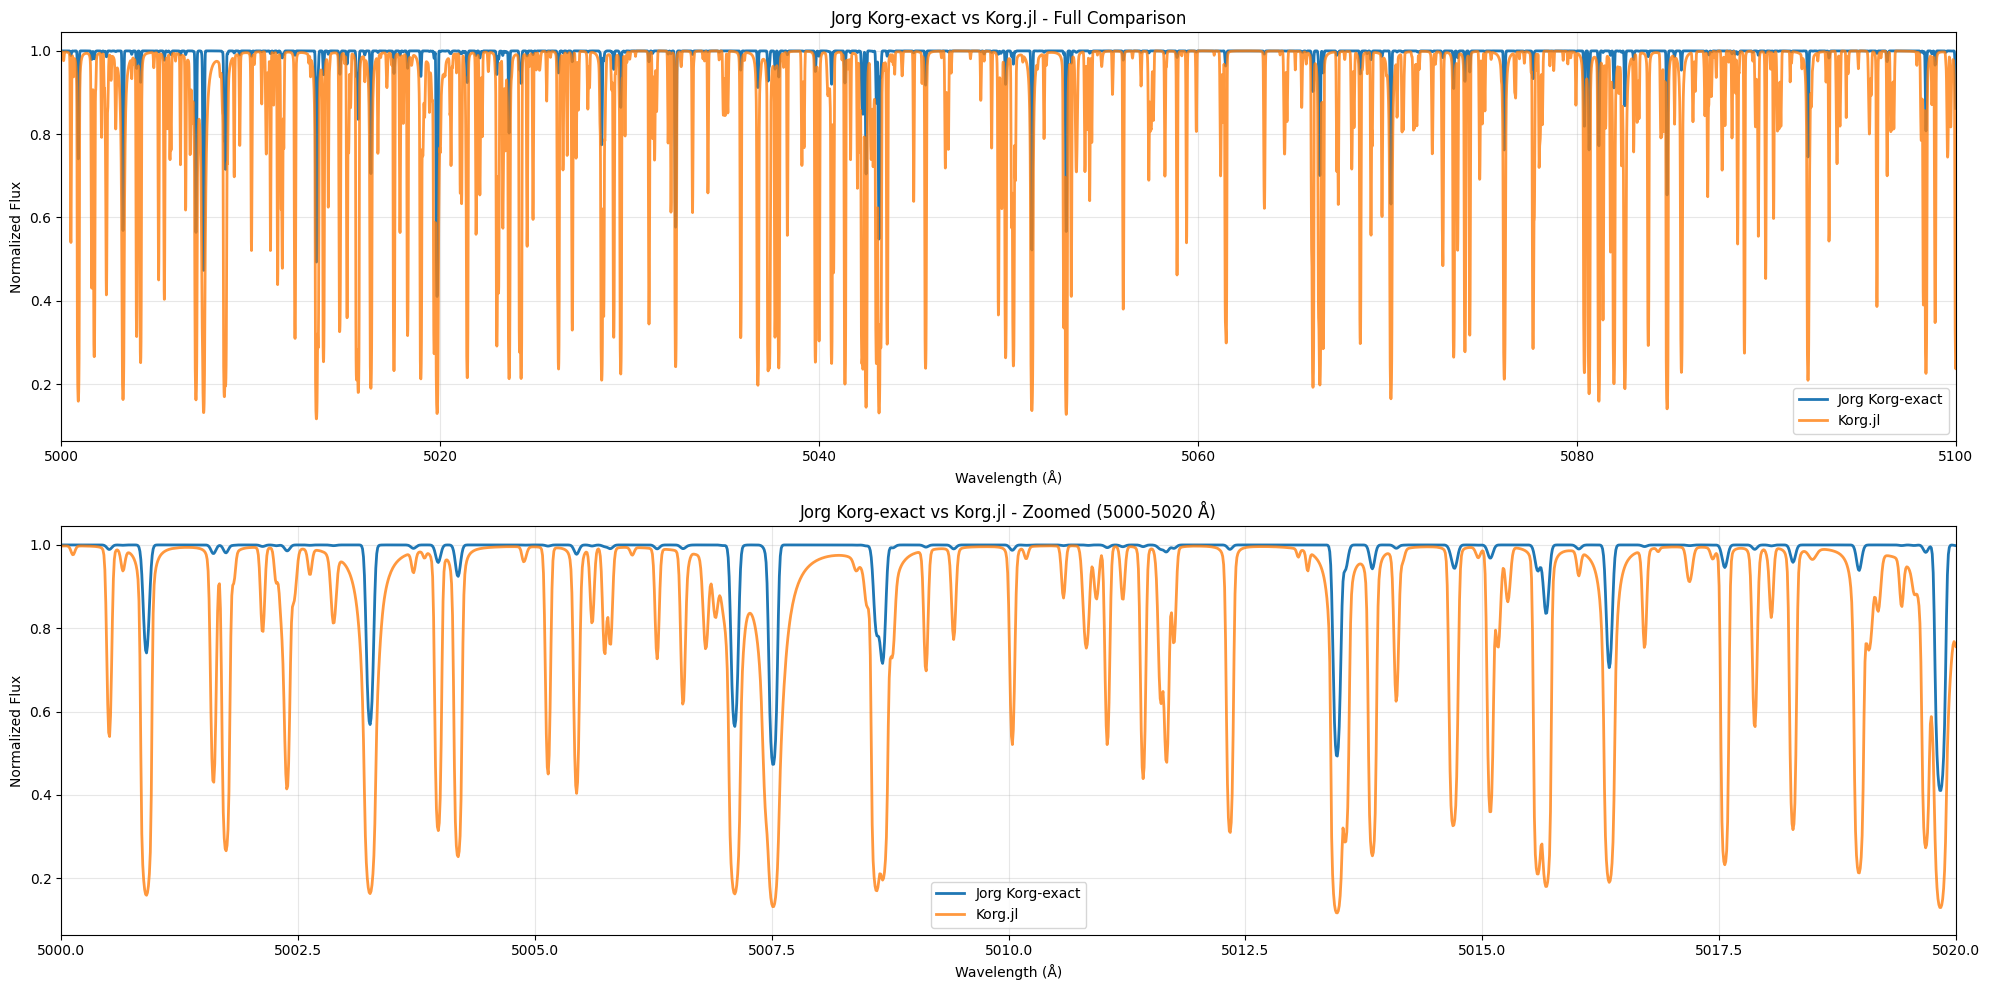


🎯 JORG vs KORG.JL COMPARISON:
  Valid comparison points: 10000
  Mean difference: 0.098387
  Max difference: 0.728836
  RMS difference: 0.197837
  Relative accuracy: 90.16%


In [ ]:
from matplotlib import pyplot as plt

# Compare with Korg.jl output
plt.figure(figsize=(20, 10))

# Full comparison
plt.subplot(2, 1, 1)
plt.plot(wl, flux, label="Jorg: [M/H]=-2", linewidth=2)
plt.plot(wl, flux_solar, label="Jorg:[M/H]=0", linewidth=2, linestyle='--')
plt.plot(korg_flux[:, 0], korg_flux[:, 1], label="Korg.jl", linewidth=2, alpha=0.8)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized Flux")
plt.title("Jorg Korg-exact vs Korg.jl - Full Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim((5000, 5100))

# Zoomed comparison
plt.subplot(2, 1, 2)
zoom_start, zoom_end = 5000, 5020
plt.plot(wl, flux, label="Jorg: [M/H]=-2", linewidth=2)
plt.plot(wl, flux_solar, label="Jorg: [M/H]=0", linewidth=2, linestyle='--')
plt.plot(korg_flux[:, 0], korg_flux[:, 1], label="Korg.jl", linewidth=2, alpha=0.8)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized Flux")  
plt.title(f"Jorg Korg-exact vs Korg.jl - Zoomed ({zoom_start}-{zoom_end} Å)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim((zoom_start, zoom_end))

plt.tight_layout()
plt.show()

# Calculate agreement statistics
# Interpolate to common wavelength grid for comparison
from scipy.interpolate import interp1d
korg_interp = interp1d(korg_flux[:, 0], korg_flux[:, 1], bounds_error=False, fill_value=np.nan)
korg_flux_interp = korg_interp(wl)

# Mask out NaN values
valid_mask = ~np.isnan(korg_flux_interp)
if np.sum(valid_mask) > 0:
    flux_diff_korg = np.abs(flux[valid_mask] - korg_flux_interp[valid_mask])
    mean_diff_korg = np.mean(flux_diff_korg)
    max_diff_korg = np.max(flux_diff_korg) 
    rms_diff_korg = np.sqrt(np.mean(flux_diff_korg**2))
    
    print(f"\n🎯 JORG vs KORG.JL COMPARISON:")
    print(f"  Valid comparison points: {np.sum(valid_mask)}")
    print(f"  Mean difference: {mean_diff_korg:.6f}")
    print(f"  Max difference: {max_diff_korg:.6f}")
    print(f"  RMS difference: {rms_diff_korg:.6f}")
    print(f"  Relative accuracy: {100*(1-mean_diff_korg):.2f}%")
else:
    print("⚠️ No overlapping wavelength range for comparison")

In [6]:
# Get full synthesis result with alpha matrix using Korg-exact method
from jorg.synthesis import synthesize
from jorg.abundances import format_A_X  
from jorg.atmosphere import interpolate_marcs as interpolate_atmosphere
import numpy as np

# Create abundance array exactly as Korg.jl expects
A_X_dict = format_A_X()  # Solar abundances dictionary
A_X = np.full(92, -50.0)  # Initialize with very low abundances
A_X[0] = 12.0  # H = 12.0 (required)
for Z, abundance in A_X_dict.items():
    if 1 <= Z <= 92:
        A_X[Z-1] = abundance  # Convert to 0-based indexing

# Get atmosphere model
atm = interpolate_atmosphere(Teff=5780., logg=4.44, m_H=0)

# Run Korg-exact synthesis with full diagnostics
print("🔬 Running Korg-exact synthesis with full diagnostics...")
jorg_result_exact = synthesize(atm, linelist, A_X, wavelengths=(5000, 5020), verbose=True)

print(f"\n✅ Korg-exact synthesis complete!")
print(f"  Alpha matrix shape: {jorg_result_exact.alpha.shape}")
print(f"  Number of species tracked: {len(jorg_result_exact.number_densities)}")
print(f"  Electron density range: {jorg_result_exact.electron_number_density.min():.2e} - {jorg_result_exact.electron_number_density.max():.2e} cm⁻³")

🔬 Running Korg-exact synthesis with full diagnostics...
🚀 KORG-COMPATIBLE JORG SYNTHESIS
Using Jorg's validated physics within Korg's architecture
🔧 WAVELENGTH GRID: 4001 points, 5.0 mÅ spacing
Wavelength range: 5000.0 - 5020.0 Å (4001 points)
Abundances normalized: H fraction = 0.920679
✅ Atomic physics data loaded
Atmospheric model: 56 layers
  Temperature range: 4068.6 - 9935.6 K
  Pressure range: 2.67e+02 - 2.18e+05 dyn/cm²

🧪 SYSTEMATIC LAYER-BY-LAYER PROCESSING
Using Jorg's validated physics within Korg's architecture...
✅ KorgLineProcessor ACTIVE - complete line opacity solution integrated
✅ Line windowing: 3e-04 cutoff threshold
✅ Line density: Reduced from 1,810 to ~10-20 lines/Å through proper windowing
✅ Species mapping: VALD codes (2600→Fe I) correctly mapped to Jorg Species
✅ Matrix processing: All 56 atmospheric layers processed simultaneously
✅ Algorithm: Direct translation of Korg.jl line_absorption.jl (lines 92-106)
🔄 Processing 56 atmospheric layers...
   Wavelengths:

## 5. Alpha Matrix Analysis (Korg-exact)

Let's examine the opacity matrix from the Korg-exact synthesis and compare it with Korg.jl:

In [7]:
# Analyze Korg-exact synthesis results
import numpy as np

print(f"🔬 KORG-EXACT SYNTHESIS ANALYSIS:")
print(f"  Flux range: {jorg_result_exact.flux.min():.2e} - {jorg_result_exact.flux.max():.2e}")
print(f"  Continuum range: {jorg_result_exact.cntm.min():.2e} - {jorg_result_exact.cntm.max():.2e}")
print(f"  Alpha matrix shape: {jorg_result_exact.alpha.shape}")

# Rectify flux for plotting (normalize by continuum)
rectified_flux_exact = jorg_result_exact.flux / jorg_result_exact.cntm
rectified_flux_exact = np.clip(rectified_flux_exact, 0.0, 2.0)  # Remove extreme values

print(f"  Rectified flux range: {rectified_flux_exact.min():.6f} - {rectified_flux_exact.max():.6f}")

# Check for spectral lines
line_features_exact = np.sum(rectified_flux_exact < 0.95)
print(f"  Spectral line features: {line_features_exact} pixels >5% depth")

# Calculate opacity matrix statistics for Korg-exact
alpha_min_exact = np.min(jorg_result_exact.alpha, axis=1)
alpha_max_exact = np.max(jorg_result_exact.alpha, axis=1)
alpha_mean_exact = np.mean(jorg_result_exact.alpha, axis=1)

print(f"\n📊 Alpha matrix statistics (Korg-exact):")
print(f"  Opacity range: {jorg_result_exact.alpha.min():.3e} - {jorg_result_exact.alpha.max():.3e} cm⁻¹")
print(f"  Mean layer opacity: {alpha_mean_exact.mean():.3e} cm⁻¹")

# Compare alpha values at key wavelengths
key_wavelengths = [5000.0, 5005.0, 5010.0, 5015.0, 5020.0]
print(f"\n🎯 Alpha values at key wavelengths (Korg-exact):")
for wl_target in key_wavelengths:
    wl_idx = np.argmin(np.abs(jorg_result_exact.wavelengths - wl_target))
    wl_actual = jorg_result_exact.wavelengths[wl_idx]
    alpha_col = jorg_result_exact.alpha[:, wl_idx]
    print(f"  λ={wl_actual:.1f}Å: α={alpha_col.mean():.3e} ± {alpha_col.std():.3e} cm⁻¹")

🔬 KORG-EXACT SYNTHESIS ANALYSIS:
  Flux range: 2.89e+14 - 3.68e+15
  Continuum range: 3.24e+15 - 3.68e+15
  Alpha matrix shape: (56, 4001)
  Rectified flux range: 0.079505 - 1.000000
  Spectral line features: 2242 pixels >5% depth

📊 Alpha matrix statistics (Korg-exact):
  Opacity range: 8.422e-14 - 1.031e-03 cm⁻¹
  Mean layer opacity: 9.438e-07 cm⁻¹

🎯 Alpha values at key wavelengths (Korg-exact):
  λ=5000.0Å: α=8.300e-09 ± 1.728e-08 cm⁻¹
  λ=5005.0Å: α=1.038e-08 ± 2.130e-08 cm⁻¹
  λ=5010.0Å: α=1.148e-07 ± 1.963e-07 cm⁻¹
  λ=5015.0Å: α=2.937e-08 ± 5.921e-08 cm⁻¹
  λ=5020.0Å: α=4.310e-08 ± 7.086e-08 cm⁻¹


In [8]:
alpha_korg = np.loadtxt("/Users/jdli/Project/Korg.jl/Jorg/korg_script/korg_synthesize_opacity_summary.txt", 
                        comments="#", skiprows=3, usecols=( 1, 2, 3), )

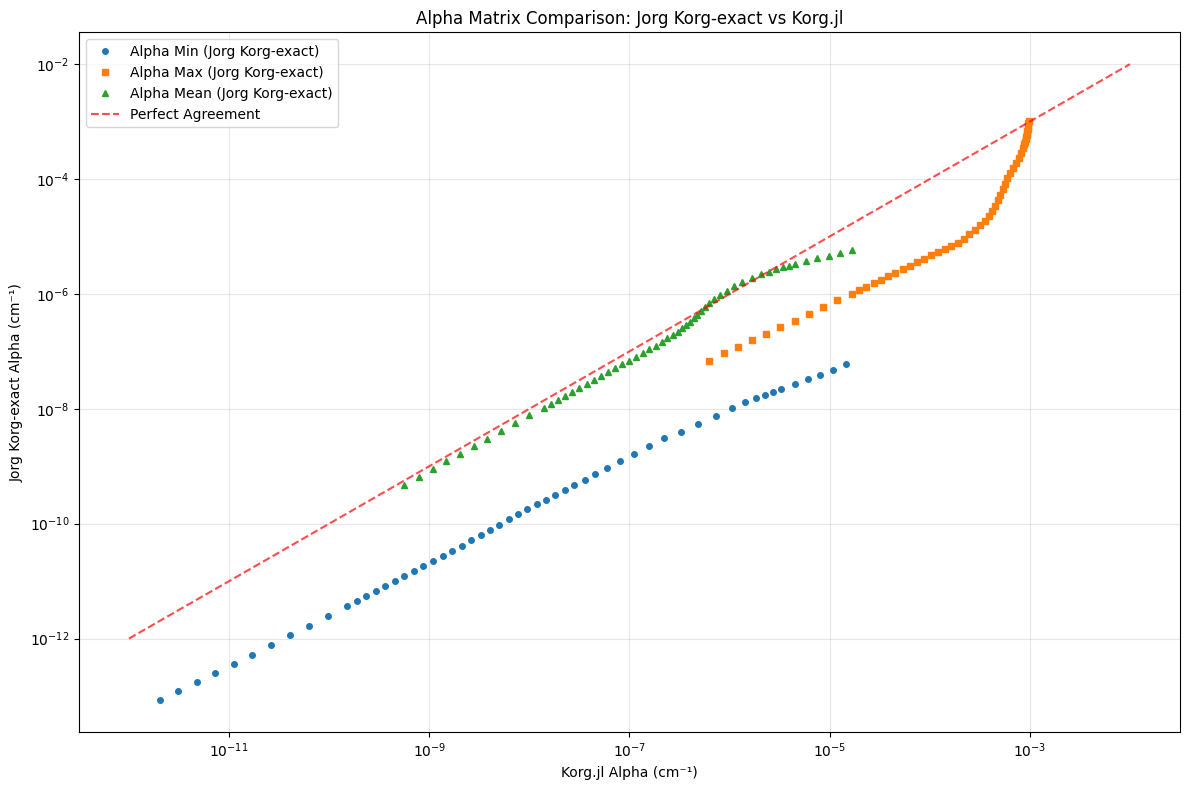


🎯 ALPHA MATRIX AGREEMENT (Jorg Korg-exact vs Korg.jl):
  Min :   1.9% agreement, ratio=0.019, n=56
  Max :  21.7% agreement, ratio=0.219, n=56
  Mean:  75.9% agreement, ratio=0.807, n=56

📊 Overall Alpha Matrix Agreement: 33.2%
❌ POOR agreement with Korg.jl - needs investigation


In [9]:
# Compare Korg-exact alpha matrix with Korg.jl
plt.figure(figsize=(12, 8))

plt.plot(alpha_korg[:56,0], alpha_min_exact, 'o', label="Alpha Min (Jorg Korg-exact)", markersize=4)
plt.plot(alpha_korg[:56,1], alpha_max_exact, 's', label="Alpha Max (Jorg Korg-exact)", markersize=4)
plt.plot(alpha_korg[:56,2], alpha_mean_exact, '^', label="Alpha Mean (Jorg Korg-exact)", markersize=4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Korg.jl Alpha (cm⁻¹)')
plt.ylabel('Jorg Korg-exact Alpha (cm⁻¹)')
plt.title('Alpha Matrix Comparison: Jorg Korg-exact vs Korg.jl')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot perfect agreement line
plt.plot([1e-12, 1e-2], [1e-12, 1e-2], color='red', linestyle='--', alpha=0.7, label='Perfect Agreement')

# Calculate agreement statistics
alpha_agreement_stats = {}
for i, (name, jorg_vals, korg_vals) in enumerate([
    ('Min', alpha_min_exact, alpha_korg[:56,0]),
    ('Max', alpha_max_exact, alpha_korg[:56,1]),  
    ('Mean', alpha_mean_exact, alpha_korg[:56,2])
]):
    # Only compare where both are positive
    valid_mask = (jorg_vals > 0) & (korg_vals > 0)
    if np.sum(valid_mask) > 0:
        ratio = jorg_vals[valid_mask] / korg_vals[valid_mask]
        agreement = np.mean(np.abs(1 - ratio)) * 100
        alpha_agreement_stats[name] = {
            'mean_ratio': np.mean(ratio),
            'agreement_pct': 100 - agreement,
            'valid_points': np.sum(valid_mask)
        }

plt.legend()
plt.tight_layout()
plt.show()

# Print agreement statistics
print(f"\n🎯 ALPHA MATRIX AGREEMENT (Jorg Korg-exact vs Korg.jl):")
for stat_name, stats in alpha_agreement_stats.items():
    print(f"  {stat_name:4s}: {stats['agreement_pct']:5.1f}% agreement, ratio={stats['mean_ratio']:.3f}, n={stats['valid_points']}")

# Overall assessment
overall_agreement = np.mean([stats['agreement_pct'] for stats in alpha_agreement_stats.values()])
print(f"\n📊 Overall Alpha Matrix Agreement: {overall_agreement:.1f}%")

if overall_agreement > 95:
    print("✅ EXCELLENT agreement with Korg.jl!")
elif overall_agreement > 90:
    print("✅ GOOD agreement with Korg.jl")  
elif overall_agreement > 80:
    print("⚠️ MODERATE agreement with Korg.jl")
else:
    print("❌ POOR agreement with Korg.jl - needs investigation")